#### **Installing and importing necessary Libraries/Packages**

In [ ]:
pip install spotipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
#from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

#### **Setting up the API and functions to retrieve playlist information**

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up the credentials
client_id = '235d9e7173274451a15c94d671b9ec6a'
client_secret = 'ba6759c6e304499bab131355689dd995'

# Authenticate
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Use the API
# Use the API
results = sp.search(q='artist:Daft Punk', type='artist')
print(results)

{'artists': {'href': 'https://api.spotify.com/v1/search?query=artist%3ADaft+Punk&type=artist&offset=0&limit=10', 'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4tZwfgrHOc3mvqYlEYSvVi'}, 'followers': {'href': None, 'total': 9930677}, 'genres': ['electro', 'filter house', 'rock'], 'href': 'https://api.spotify.com/v1/artists/4tZwfgrHOc3mvqYlEYSvVi', 'id': '4tZwfgrHOc3mvqYlEYSvVi', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eba7bfd7835b5c1eee0c95fa6e', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab67616100005174a7bfd7835b5c1eee0c95fa6e', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f178a7bfd7835b5c1eee0c95fa6e', 'width': 160}], 'name': 'Daft Punk', 'popularity': 79, 'type': 'artist', 'uri': 'spotify:artist:4tZwfgrHOc3mvqYlEYSvVi'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/3koSTh1rFReMYVMCwZTLZG'}, 'followers': {'href': None, 'total': 297}, 'genres': [], 'href': 'ht

In [ ]:
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break

    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])

    return playlist_name, names, artists, uris

In [ ]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):

    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)

    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))
        # ^ DEBUG STATEMENT ^

        # access audio features for given track URI via spotipy
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [ ]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])


In [ ]:
# Assuming user_config is a dictionary with necessary user information
user_config = {
    'username': 'Oumou'
}

# Assuming the function get_features_for_playlist is defined elsewhere in your code
df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:37i9dQZEVXbNG2KDcFcKOF')
df


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Please Please Please,Sabrina Carpenter,spotify:track:5N3hjp1WNayUPZrA8kJmJP,0.274000,0.669,0.586,0.000000,0.1040,-6.073,0.0540,107.071,0.5790,Top Songs - Global
1,Espresso,Sabrina Carpenter,spotify:track:2qSkIjg1o9h3YT9RAgYN75,0.107000,0.701,0.760,0.000065,0.1850,-5.478,0.0285,103.969,0.6900,Top Songs - Global
2,BIRDS OF A FEATHER,Billie Eilish,spotify:track:6dOtVTDdiauQNBQEDOtlAB,0.200000,0.747,0.507,0.060800,0.1170,-10.171,0.0358,104.978,0.4380,Top Songs - Global
3,MILLION DOLLAR BABY,Tommy Richman,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,0.097300,0.852,0.697,0.000370,0.0678,-5.520,0.0439,138.029,0.9190,Top Songs - Global
4,Gata Only,FloyyMenor,spotify:track:6XjDF6nds4DE2BBbagZol6,0.446000,0.791,0.499,0.000024,0.0899,-8.472,0.0509,99.986,0.6690,Top Songs - Global
5,Too Sweet,Hozier,spotify:track:5Z0UnEtpLDQyYlWwgi8m9C,0.029500,0.741,0.620,0.000809,0.0398,-5.505,0.0412,117.038,0.9340,Top Songs - Global
6,Beautiful Things,Benson Boone,spotify:track:3xkHsmpQCBMytMJNiDf3Ii,0.151000,0.472,0.471,0.000000,0.1400,-5.692,0.0603,105.029,0.2190,Top Songs - Global
7,Houdini,Eminem,spotify:track:2HYFX63wP3otVIvopRS99Z,0.029200,0.936,0.887,0.000002,0.0582,-2.760,0.0683,127.003,0.8890,Top Songs - Global
8,A Bar Song (Tipsy),Shaboozey,spotify:track:5fZJQrFKWQLb7FpJXZ1g7K,0.072000,0.722,0.706,0.000000,0.0670,-4.857,0.0292,80.969,0.5990,Top Songs - Global
9,I Had Some Help (Feat. Morgan Wallen),Post Malone,spotify:track:7221xIgOnuakPdLqT0F3nP,0.007570,0.638,0.855,0.000000,0.2450,-4.860,0.0264,127.986,0.7310,Top Songs - Global


#### **Hierarchichal Clustering**

 **Features scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale
numerical_columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print(df)


                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
df.head()

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Please Please Please,Sabrina Carpenter,spotify:track:5N3hjp1WNayUPZrA8kJmJP,0.280664,0.042821,-0.340056,-0.240334,-0.421262,0.053910,-0.083543,-0.603235,0.115029,Top Songs - Global
1,Espresso,Sabrina Carpenter,spotify:track:2qSkIjg1o9h3YT9RAgYN75,-0.481090,0.258954,0.840034,-0.239835,0.394981,0.320013,-0.693956,-0.707638,0.570648,Top Songs - Global
2,BIRDS OF A FEATHER,Billie Eilish,spotify:track:6dOtVTDdiauQNBQEDOtlAB,-0.056880,0.569645,-0.875844,0.223526,-0.290260,-1.778853,-0.519210,-0.673679,-0.463729,Top Songs - Global
3,MILLION DOLLAR BABY,Tommy Richman,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,-0.525336,1.278830,0.412760,-0.237511,-0.786052,0.301230,-0.325314,0.438709,1.510618,Top Songs - Global
4,Gata Only,FloyyMenor,spotify:track:6XjDF6nds4DE2BBbagZol6,1.065226,0.866827,-0.930101,-0.240150,-0.563349,-1.019003,-0.157750,-0.841693,0.484450,Top Songs - Global


**Hierarchical clustering using all features**

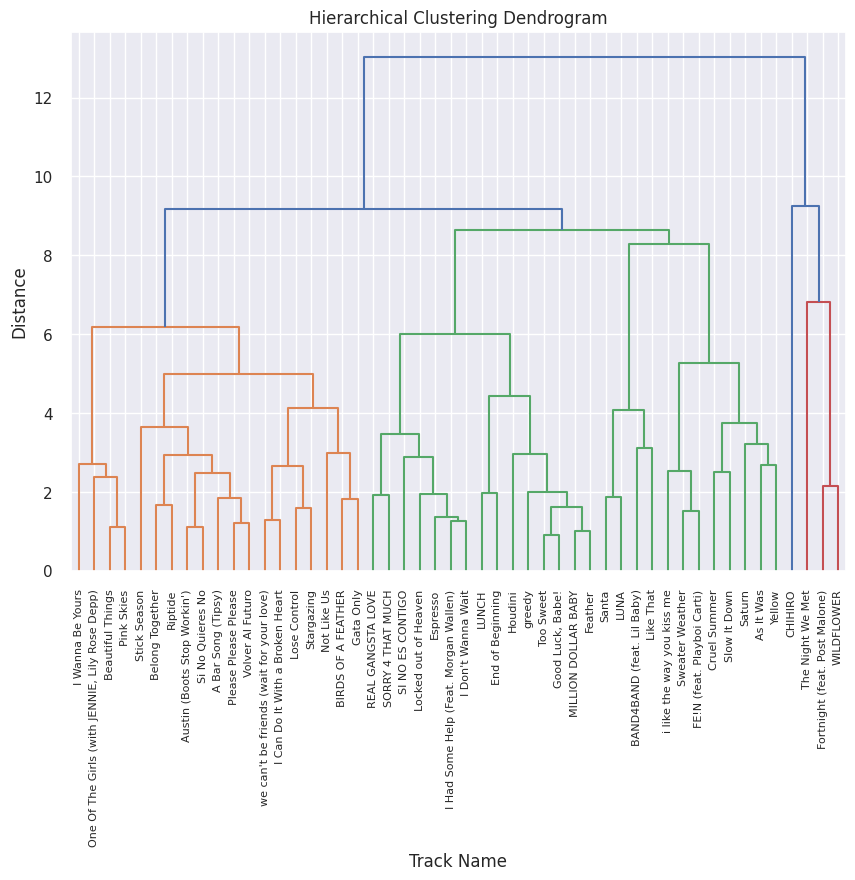

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Select the features for clustering
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

X=df[features]

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['name'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Track Name')
plt.ylabel('Distance')
plt.show()

# Get cluster labels
max_d = 5  # Maximum distance for cutting the tree to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame
df['cluster'] = clusters

print(df)


**Random forest to determine importance of each feature in clustering**

            Feature  Importance
4          liveness    0.160791
8           valence    0.148277
5          loudness    0.133218
1      danceability    0.123683
7             tempo    0.107835
6       speechiness    0.101885
2            energy    0.097920
0      acousticness    0.073850
3  instrumentalness    0.052540


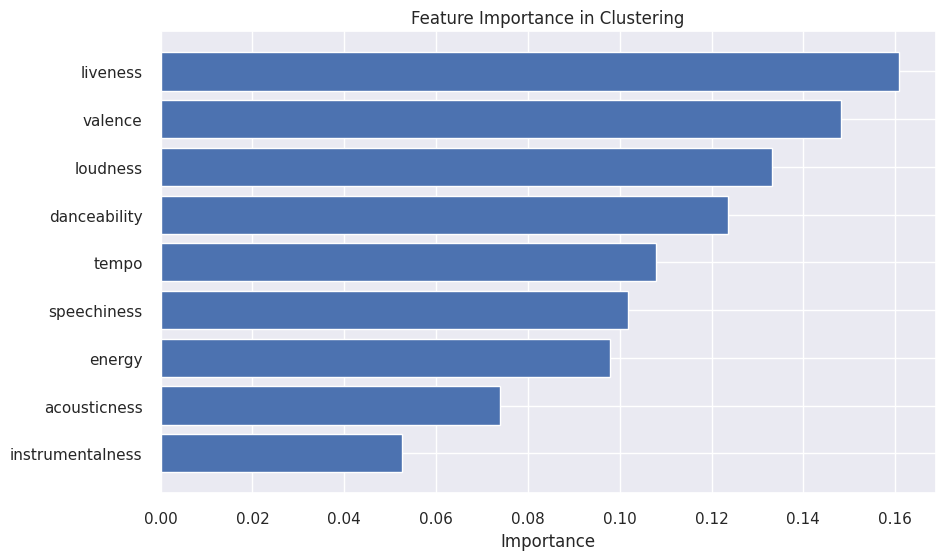

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use a random forest to determine feature importance
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, df['cluster'])

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Clustering')
plt.gca().invert_yaxis()
plt.show()

**Hierarchical clustering using liveness and valence**

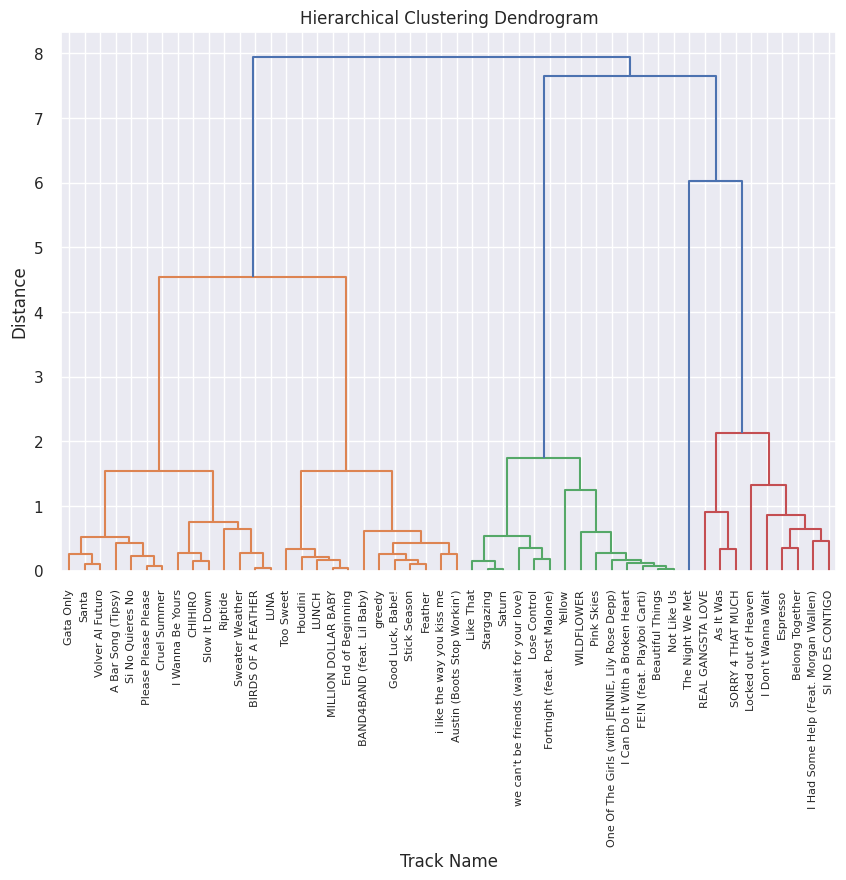

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Select the features for clustering
features = ['liveness','valence']

X=df[features]

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['name'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Track Name')
plt.ylabel('Distance')
plt.show()

# Get cluster labels
max_d = 5  # Maximum distance for cutting the tree to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame
df['cluster'] = clusters

print(df)

In [ ]:
# Calculate and print the characteristics of each feature for each cluster
cluster_stats = []

for cluster_label in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_label][features]
    stats = cluster_data.describe().reset_index()
    stats['cluster'] = cluster_label
    cluster_stats.append(stats)

# Concatenate all cluster statistics into a single DataFrame
all_cluster_stats = pd.concat(cluster_stats)

# Reorder columns to place 'cluster' first
all_cluster_stats = all_cluster_stats[['cluster'] + [col for col in all_cluster_stats.columns if col != 'cluster']]

# Print the statistics in a table format with separation lines between clusters
tables = []
for cluster_label in all_cluster_stats['cluster'].unique():
    cluster_table = all_cluster_stats[all_cluster_stats['cluster'] == cluster_label]
    tables.append(tabulate(cluster_table, headers='keys', tablefmt='psql'))

print('\n\n'.join(tables))

+----+-----------+---------+------------+-------------+
|    |   cluster | index   |   liveness |     valence |
|----+-----------+---------+------------+-------------|
|  0 |         1 | count   | 26         | 26          |
|  1 |         1 | mean    | -0.523157  |  0.555334   |
|  2 |         1 | std     |  0.235778  |  0.71002    |
|  3 |         1 | min     | -1.06821   | -0.627916   |
|  4 |         1 | 25%     | -0.635904  | -0.00811083 |
|  5 |         1 | 50%     | -0.499863  |  0.441351   |
|  6 |         1 | 75%     | -0.388511  |  1.11862    |
|  7 |         1 | max     |  0.0523605 |  1.61734    |
+----+-----------+---------+------------+-------------+

+----+-----------+---------+------------+-----------+
|    |   cluster | index   |   liveness |   valence |
|----+-----------+---------+------------+-----------|
|  0 |         3 | count   |   9        | 9         |
|  1 |         3 | mean    |   1.14516  | 0.520024  |
|  2 |         3 | std     |   0.605487 | 0.422442  |
|  

**Hierarchical clustering using energy**





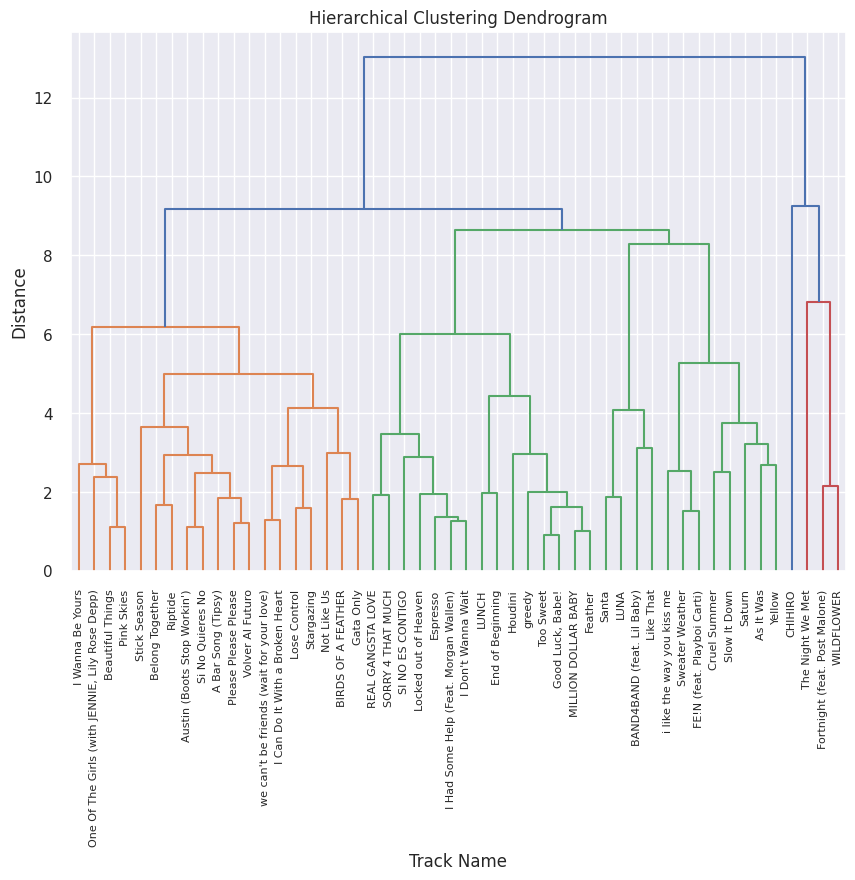

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
# Select the features for clustering
features = ['energy']

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['name'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Track Name')
plt.ylabel('Distance')
plt.show()

# Get cluster labels
max_d = 5  # Maximum distance for cutting the tree to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame
df['cluster'] = clusters

print(df)

**Hierarchichal Clustering using liveness**

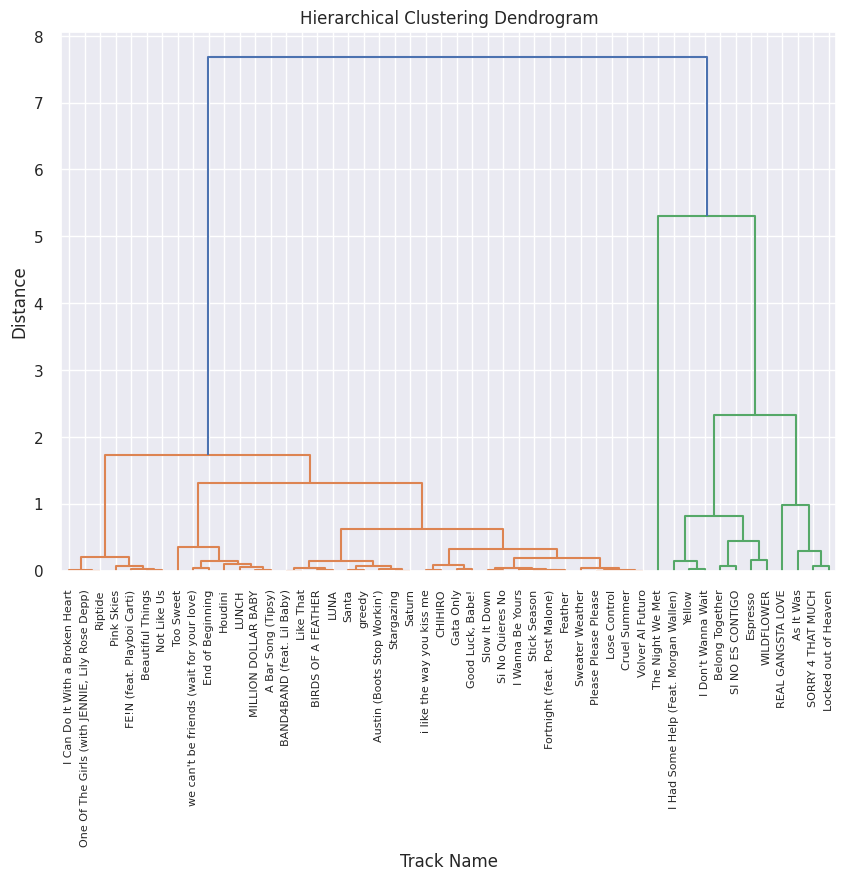

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:

# Select the features for clustering
features = [ 'liveness']

X=df[features]

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['name'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Track Name')
plt.ylabel('Distance')
plt.show()

# Get cluster labels
max_d = 5  # Maximum distance for cutting the tree to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame
df['cluster'] = clusters

print(df)

**Hierarchical clustering using tempo**


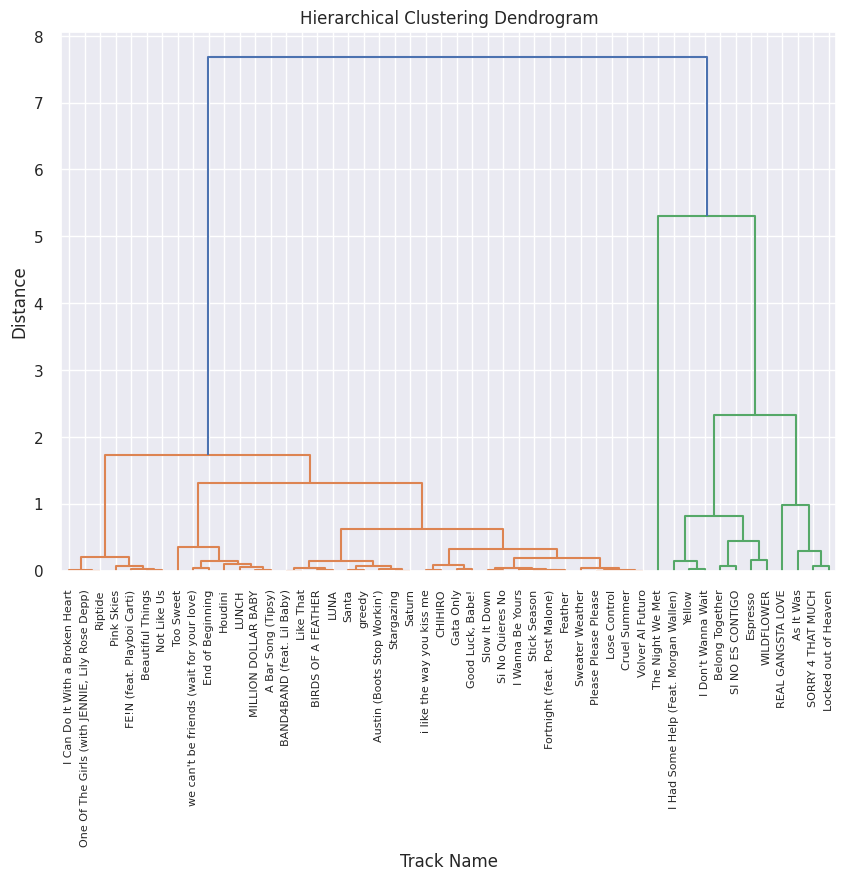

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
# Select the features for clustering
features = [ 'tempo']

X=df[features]

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df['name'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Track Name')
plt.ylabel('Distance')
plt.show()

# Get cluster labels
max_d = 5  # Maximum distance for cutting the tree to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Add cluster labels to the DataFrame
df['cluster'] = clusters

print(df)

#### **DBSCAN Clustering**

**DBSCAN with all features**

**Tuning eps using KNN distance plot**

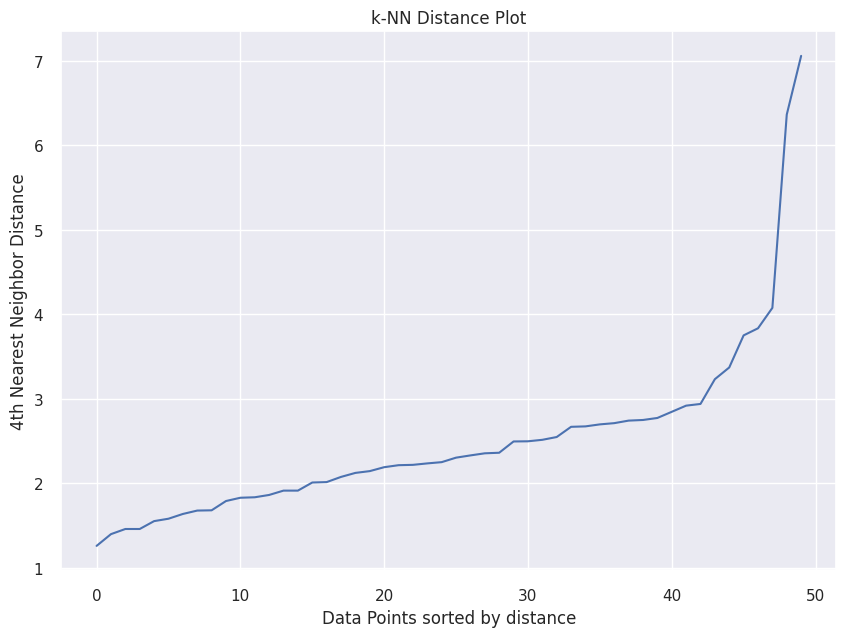

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Assuming df is already defined and features are already scaled
# Select the features for clustering
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Use the scaled features
X = df[features].values

# Find the optimal value for eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort and plot the distances
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.title('k-NN Distance Plot')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()


We determined that the optimal value for eps is between 2.5 and 3 because that is where the knee is located ie. that is when the slope of the curve changes.We settled for 2.5 and vizualed the clusters below.

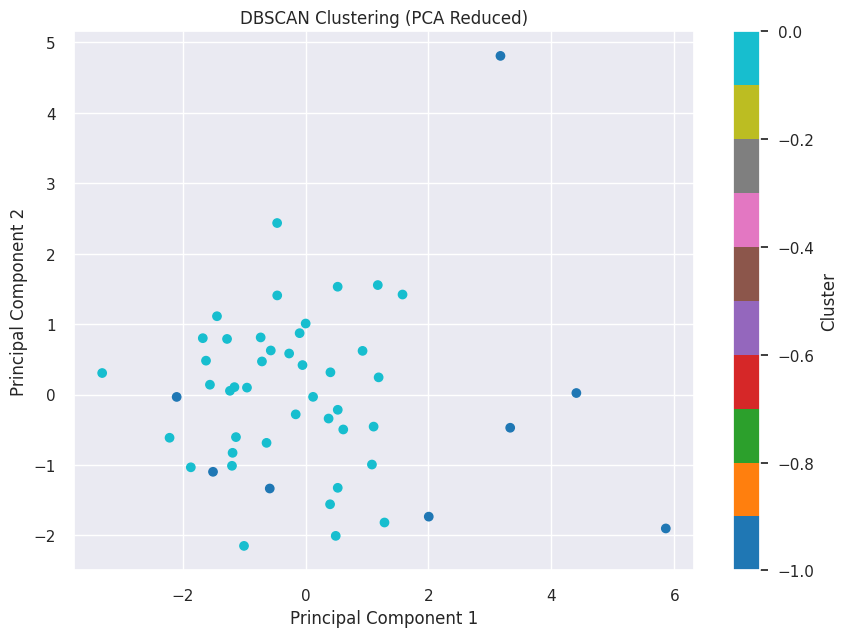

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
# Perform DBSCAN clustering with tuned parameters
# Adjust eps based on the knee point in the k-NN distance plot
dbscan = DBSCAN(eps=2.5, min_samples=5)  # Example values, adjust as needed
clusters = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', marker='o')
plt.title('DBSCAN Clustering (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Print the DataFrame with cluster labels
print(df)


**Tuning min_samples using silhouette score as a metric**

For min_samples = 3, Silhouette Score: 0.3563876156719998


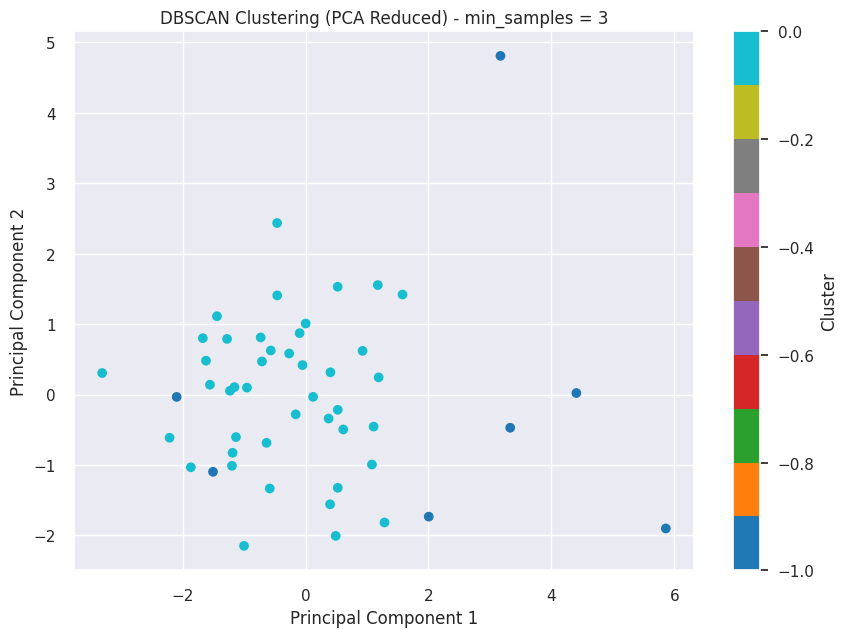

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

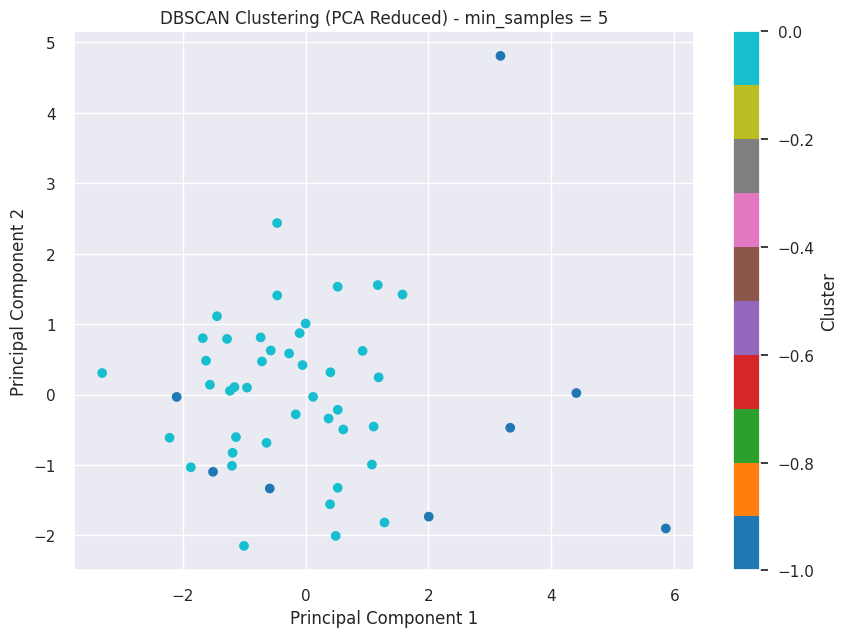

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

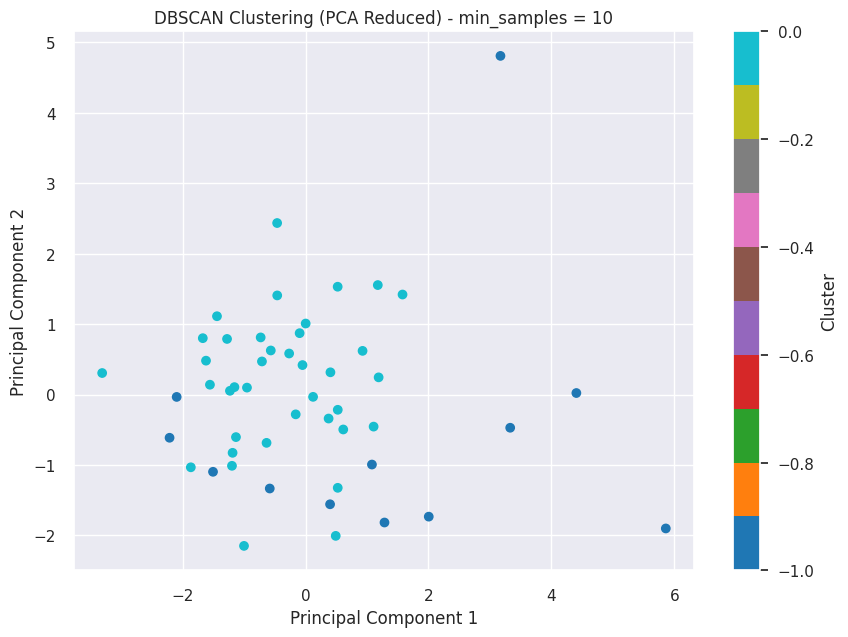

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

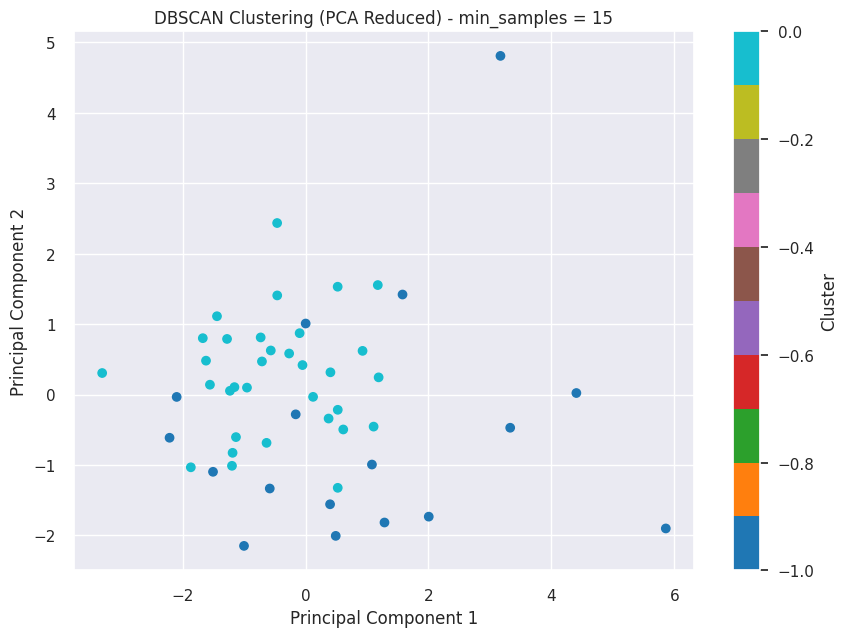

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
from sklearn.metrics import silhouette_score

# Set eps based on the knee in the plot
eps = 2.5  # Example value, adjust based on the plot

# Tune min_samples
min_samples_list = [3, 5, 10, 15]  # Example values to try

for min_samples in min_samples_list:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

    # Evaluate clustering performance (e.g., silhouette score)
    if len(set(clusters)) > 1:  # Check if there's more than one cluster
        silhouette_avg = silhouette_score(X, clusters)
        print(f"For min_samples = {min_samples}, Silhouette Score: {silhouette_avg}")
    else:
        print(f"For min_samples = {min_samples}, Only noise points detected.")

    # Add cluster labels to the DataFrame for visualization
    df['cluster'] = clusters

    # Visualize clustering results (e.g., PCA reduced plot)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 7))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', marker='o')
    plt.title(f'DBSCAN Clustering (PCA Reduced) - min_samples = {min_samples}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # Print the DataFrame with cluster labels
    print(df)

We chose to proceed with min_samples=3 because it yielded the highest silhouette score.

**Feature Importance in clustering using eps=2.5 and min_samples=3**

            Feature  Importance
3  instrumentalness    0.143377
2            energy    0.134801
4          liveness    0.086605
5          loudness    0.058732
0      acousticness    0.052089
1      danceability    0.048994
6       speechiness    0.037919
8           valence    0.037539
7             tempo    0.027378


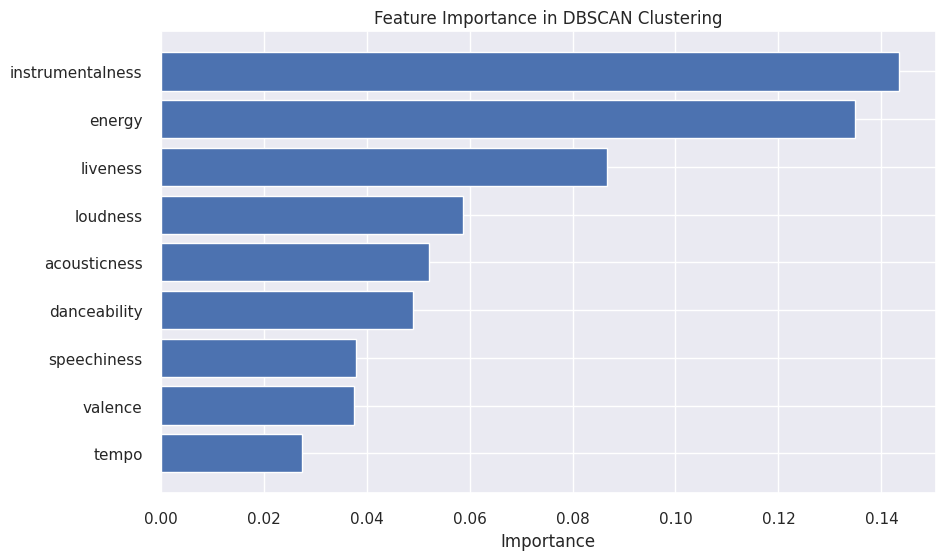

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df is already defined and features are already scaled
# Select the features for clustering
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Use the scaled features
X = df[features].values

# Perform DBSCAN clustering
# You may need to tune the eps and min_samples parameters
dbscan = DBSCAN(eps=2.5, min_samples=3)
clusters = dbscan.fit_predict(X)

# Calculate the original silhouette score
if len(set(clusters)) > 1:  # Ensure there is more than one cluster
    original_score = silhouette_score(X, clusters)
else:
    original_score = -1

# Function to calculate silhouette score after permuting a feature
def calculate_permutation_importance(X, clusters, feature_idx, random_state=None):
    X_permuted = X.copy()
    if random_state:
        np.random.seed(random_state)
    np.random.shuffle(X_permuted[:, feature_idx])
    permuted_clusters = dbscan.fit_predict(X_permuted)
    if len(set(permuted_clusters)) > 1:  # Ensure there is more than one cluster
        score = silhouette_score(X, permuted_clusters)
    else:
        score = -1  # Assign the lowest possible score if only one cluster is formed
    return score

# Calculate importances
importances = []
for i in range(X.shape[1]):
    permuted_score = calculate_permutation_importance(X, clusters, i)
    importance = original_score - permuted_score
    importances.append(importance)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in DBSCAN Clustering')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
df.cluster.unique()

array([ 0, -1])

Upon checking, we realized the DBSCAN only created one cluster and categorized other data points as noise (cluster -1) so we tried different feature combinations to see if we will have more clusters.

**DBSCAN clustering using energy, liveness,loudness and instrumentalness**

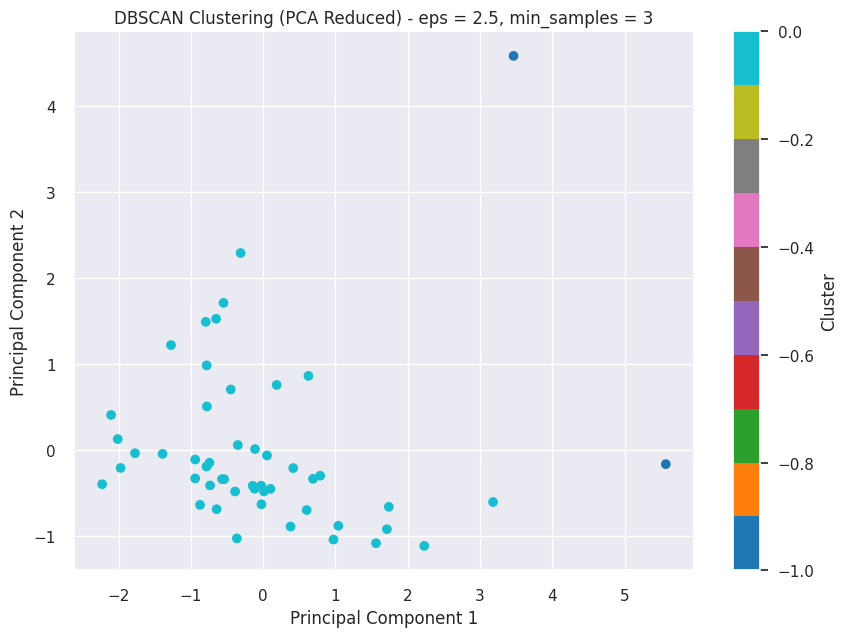

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Assuming df is already defined and features are already scaled
# Select the features for clustering
features = ['energy', 'instrumentalness','liveness','loudness']

# Use the scaled features
X = df[features].values

# Perform DBSCAN clustering
# You may need to tune the eps and min_samples parameters
eps = 2.5
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame for visualization
df['cluster'] = clusters

# Visualize clustering results (e.g., PCA reduced plot)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', marker='o')
plt.title(f'DBSCAN Clustering (PCA Reduced) - eps = {eps}, min_samples = {min_samples}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Print the DataFrame with cluster labels
print(df)


In [ ]:
df.cluster.unique()

array([ 0, -1])

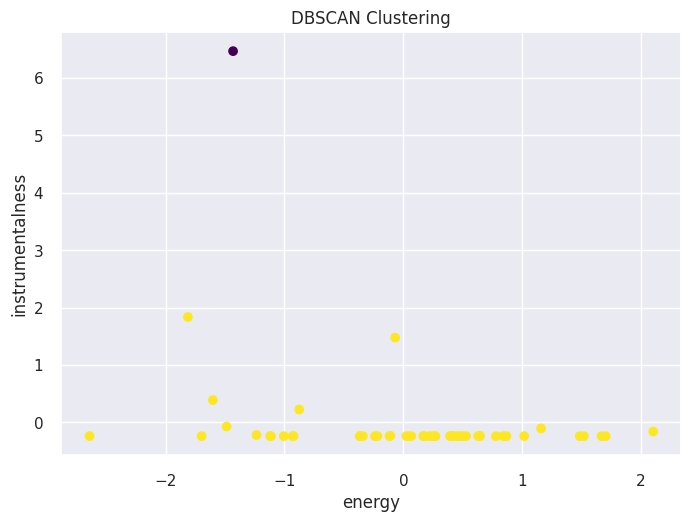

In [ ]:
# Plot the results
plt.scatter(df['energy'], df['instrumentalness'], c=df['cluster'], cmap='viridis', marker='o')
plt.xlabel('energy')
plt.ylabel('instrumentalness')
plt.title('DBSCAN Clustering')
plt.show()

**DBSCAN clustering using instrumentalness**

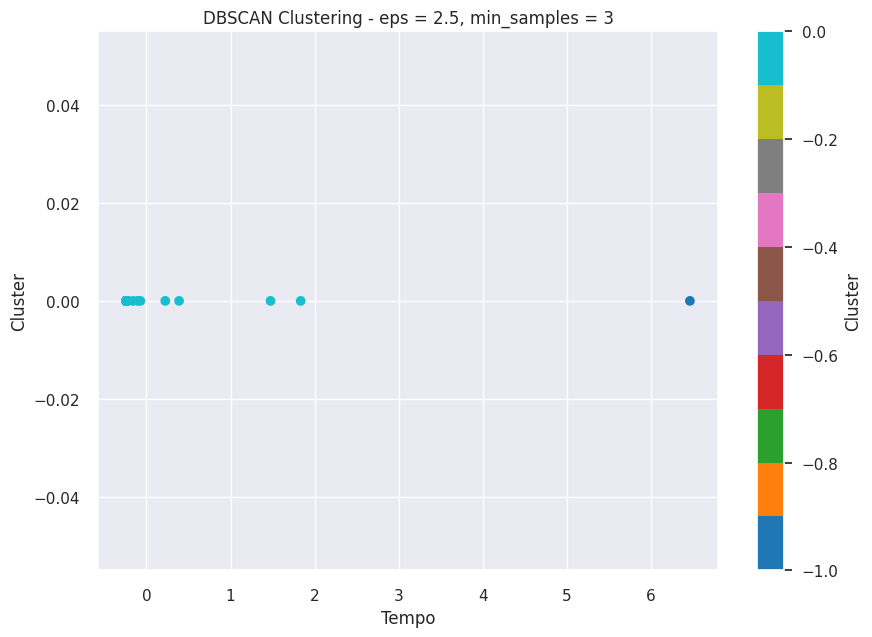

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming df is already defined and features are already scaled
# Select the feature for clustering
features = ['instrumentalness']

# Use the scaled feature
X = df[features].values

# Perform DBSCAN clustering
# You may need to tune the eps and min_samples parameters
eps = 2.5
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame for visualization
df['cluster'] = clusters

# Visualize clustering results
plt.figure(figsize=(10, 7))
plt.scatter(X, [0]*len(X), c=clusters, cmap='tab10', marker='o')
plt.title(f'DBSCAN Clustering - eps = {eps}, min_samples = {min_samples}')
plt.xlabel('Tempo')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster')
plt.show()

# Print the DataFrame with cluster labels
print(df)


**DBSCAN clustering using energy**

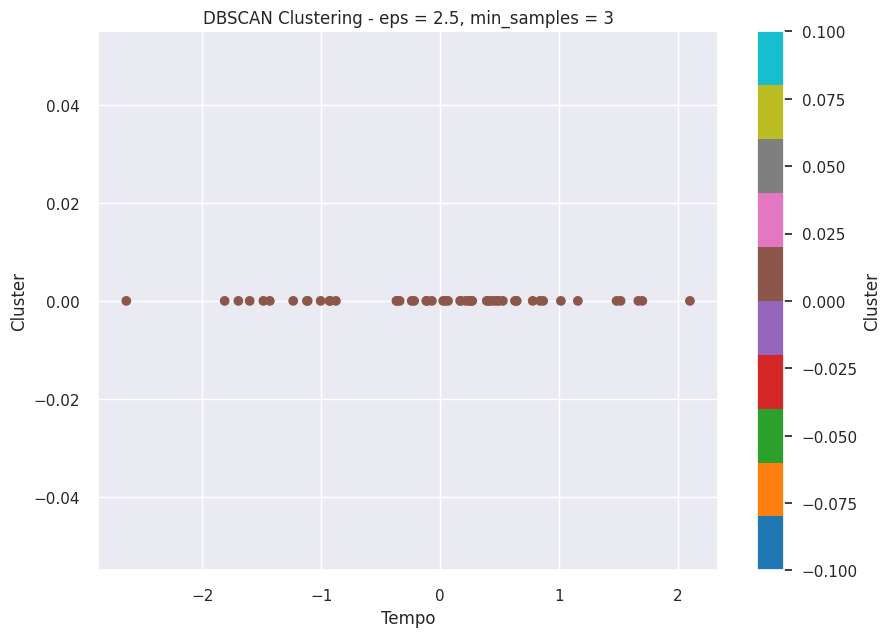

                                              name             artist  \
0                             Please Please Please  Sabrina Carpenter   
1                                         Espresso  Sabrina Carpenter   
2                               BIRDS OF A FEATHER      Billie Eilish   
3                              MILLION DOLLAR BABY      Tommy Richman   
4                                        Gata Only         FloyyMenor   
5                                        Too Sweet             Hozier   
6                                 Beautiful Things       Benson Boone   
7                                          Houdini             Eminem   
8                               A Bar Song (Tipsy)          Shaboozey   
9            I Had Some Help (Feat. Morgan Wallen)        Post Malone   
10                                           LUNCH      Billie Eilish   
11                                     Not Like Us     Kendrick Lamar   
12                               REAL GANGSTA LOVE 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming df is already defined and features are already scaled
# Select the feature for clustering
features = ['energy']

# Use the scaled feature
X = df[features].values

# Perform DBSCAN clustering
# You may need to tune the eps and min_samples parameters
eps = 2.5
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame for visualization
df['cluster'] = clusters

# Visualize clustering results
plt.figure(figsize=(10, 7))
plt.scatter(X, [0]*len(X), c=clusters, cmap='tab10', marker='o')
plt.title(f'DBSCAN Clustering - eps = {eps}, min_samples = {min_samples}')
plt.xlabel('Tempo')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster')
plt.show()

# Print the DataFrame with cluster labels
print(df)


Despite trying different feature combinations and tuning its hyperparameters, DBSCAN only created one cluster. It may not be suitable for this dataset. Our next step is to plot the data to look at the density and decide on a course of action from there to see if the algorithm will assign more than one cluster.